# Categorical Classification With Tensorflow
You want to classify your data into different categories.

A good exmaple of this would be recognising different animals in an image - e.g. Cat, Dog, Horse, Cow, Sheep.

In this notebook we'll be extending the work from Binary Classification notebook to recognise more than two shapes.

In [2]:
# Standard set of imports
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
#from tensorflow.data import Dataset
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# some constants for use later
image_width = 100
image_height = 100
batch_size = 30

# Training Data
We're going to generate some dummy training data. We'll generate some simple images that are blank, contain a square or a circle or a triangle. Our model will try and predict what class the image falls into.

In [4]:
labels=["blank","square","circle","triangle"]

# Data Generator
This is an infinite generator that will generate a pair of input and outpus values.

There's an important difference from our previous generator - we are now returing a one hot encoded value for our label using `tf.one_hot`.

For our different labels this will generate the following labels:

```
blank =    [1, 0, 0, 0]
square =   [0, 1, 0, 0]
circle =   [0, 0, 1, 0]
triangle = [0, 0, 0, 1]
```

In [5]:
def data_generator():
    i = 0
    while(True):
        if i >= 1000:
            i = 0
        # our output value will be the one hot encoded version of: 0,1,2,3 - corresponding to our labels - "blank", "square", "circle", "triangle"
        Y = i % 4
        X = np.zeros((image_width, image_height, 1))
        
        # size of our shape
        radius = int(np.random.uniform(10,20))
        # position of our shape
        center_x = int(np.random.uniform(radius, image_width - radius))
        center_y = int(np.random.uniform(radius, image_height - radius))
        
        if Y == 1: # generate a square
            X[center_y - radius:center_y + radius, center_x - radius:center_x + radius] = 1        
        elif Y == 2: # generate a circle
            for y in range(-radius, radius):
                for x in range(-radius, radius):
                    if x*x + y*y <= radius*radius:
                        X[y+center_y, x+center_x] = 1
        elif Y==3:
            for y in range(-radius, radius):
                for x in range(-radius, radius):
                    if abs(x) < (y+radius)/2:
                        X[y+center_y, x+center_x] = 1            
        else: # blank image
            pass
        yield X, tf.one_hot(Y, 4)
        i = i + 1

# Dataset
This creates a dataset that we can feed into the tensorflow fit function for training

In [6]:
train_dataset = tf.data.Dataset.from_generator(
    data_generator, 
    output_types = (tf.float32, tf.int32),
    output_shapes=((image_width, image_height, 1), (4))
)
train_dataset = train_dataset.batch(batch_size=batch_size)

# Visualising our training data
We can display a selection of images from our training data along with their labels.

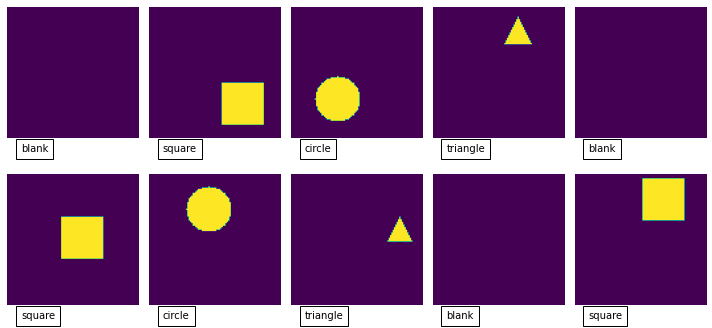

In [7]:
import itertools

def plot_images(X, Y):
    fig, axes = plt.subplots(2, 5, figsize=(10, 5))
    axes = axes.flatten()
    for x, y, ax in zip(X, tf.cast(Y, tf.float32), axes):
        # show the image
        ax.imshow(x)
        # work out the label
        label = labels[int(y)]
        # show the label beneath the plot
        ax.text(10, image_height+10, f"{label}", bbox={'facecolor': 'white', 'pad': 5})
        # turn off the axis to make the display a bit cleaner
        ax.axis("off")
    plt.tight_layout()
    plt.show()

# get a batch of images and labels from our dataset
X, Y = next(iter(train_dataset))
# and show the images along with the label - not the use of nump() to get the values from the tensor
plot_images(X, tf.argmax(Y, axis=1).numpy())

# Our very simple mode
We don't need a very complicated model for our problem, so we'll just define a small convolutional neural network with a hidden layer and an output layer. Our output layer now has 4 neurons as we have 4 different classes to predict.

It's important that the activation function should be `softmax`. This activation function will make sure that the output values 

In [8]:
model = Sequential([
    Conv2D(8, 3, 
           padding='same',
           activation='relu',
           input_shape=(image_width, image_height, 1),
           name='conv_layer'),
    MaxPooling2D(name='max_pooling'),
    Flatten(),
    Dense(
        10,
        activation='relu',
        name='hidden_layer'
    ),
    Dense(4, activation='softmax', name='output')
])

# Compile our model
For our loss function we need to use `CategoricalCrossentropy`.

Crossentropy quantifies the difference between two probability distribution.

We have more than two classes so need to use CategoricalCrossentropy for our loss function.

In [9]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_layer (Conv2D)          (None, 100, 100, 8)       80        
_________________________________________________________________
max_pooling (MaxPooling2D)   (None, 50, 50, 8)         0         
_________________________________________________________________
flatten (Flatten)            (None, 20000)             0         
_________________________________________________________________
hidden_layer (Dense)         (None, 10)                200010    
_________________________________________________________________
output (Dense)               (None, 4)                 44        
Total params: 200,134
Trainable params: 200,134
Non-trainable params: 0
_________________________________________________________________


# Fitting our model
We can now fit our model to the data. We have a very simple model to solve so we don't need to run for very many epochs to get a good fit.

In [10]:
history = model.fit(
    train_dataset,
    steps_per_epoch=200,
    epochs=10
)

Train for 200 steps
Epoch 1/10
200/200 [==============================] - 26s 131ms/step - loss: 0.9608 - accuracy: 0.5580
Epoch 2/10
200/200 [==============================] - 24s 118ms/step - loss: 0.6638 - accuracy: 0.6670
Epoch 3/10
200/200 [==============================] - 24s 122ms/step - loss: 0.6125 - accuracy: 0.6797
Epoch 4/10
200/200 [==============================] - 24s 122ms/step - loss: 0.5638 - accuracy: 0.7065
Epoch 5/10
200/200 [==============================] - 23s 116ms/step - loss: 0.4838 - accuracy: 0.7567
Epoch 6/10
200/200 [==============================] - 26s 132ms/step - loss: 0.3004 - accuracy: 0.8868
Epoch 7/10
200/200 [==============================] - 27s 137ms/step - loss: 0.1046 - accuracy: 0.9922
Epoch 8/10
200/200 [==============================] - 25s 126ms/step - loss: 0.0433 - accuracy: 0.9985
Epoch 9/10
200/200 [==============================] - 26s 130ms/step - loss: 0.0266 - accuracy: 0.9992
Epoch 10/10
200/200 [==============================] 

# Testing our model with some examples
You should end up with an accuracy approaching > 90%. Longer training should give you something approaching 100%.

Let's generate some more examples and see what the output of the model is.

In [ ]:
X, _ = next(iter(train_dataset))
X

In [13]:
# get a batch of samples from the dataset
X, _ = next(iter(train_dataset))
# ask the model to predict the output for our samples
predicted_Y = model.predict(X.numpy())
# work out the max indices
max_indices = tf.argmax(predicted_Y, axis = 1)
# show the images along with the predicted value
plot_images(X, max_indices)
# set the format to 2 decimal places
np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})
predicted_Y[:10]

<tf.Tensor: shape=(30, 100, 100, 1), dtype=float32, numpy=
array([[[[0.00],
         [0.00],
         [0.00],
         ...,
         [0.00],
         [0.00],
         [0.00]],

        [[0.00],
         [0.00],
         [0.00],
         ...,
         [0.00],
         [0.00],
         [0.00]],

        [[0.00],
         [0.00],
         [0.00],
         ...,
         [0.00],
         [0.00],
         [0.00]],

        ...,

        [[0.00],
         [0.00],
         [0.00],
         ...,
         [0.00],
         [0.00],
         [0.00]],

        [[0.00],
         [0.00],
         [0.00],
         ...,
         [0.00],
         [0.00],
         [0.00]],

        [[0.00],
         [0.00],
         [0.00],
         ...,
         [0.00],
         [0.00],
         [0.00]]],


       [[[0.00],
         [0.00],
         [0.00],
         ...,
         [0.00],
         [0.00],
         [0.00]],

        [[0.00],
         [0.00],
         [0.00],
         ...,
         [0.00],
         [0.00],


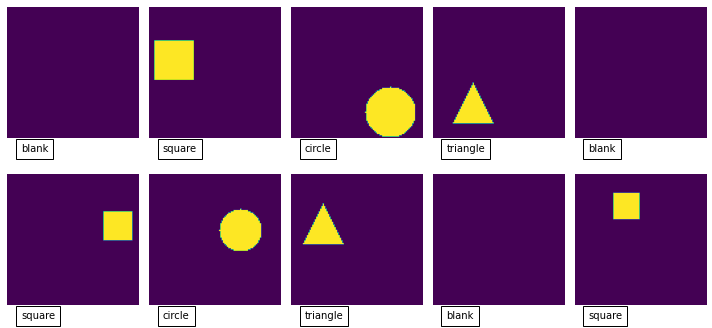

array([[1.00, 0.00, 0.00, 0.00],
       [0.00, 1.00, 0.00, 0.00],
       [0.00, 0.00, 1.00, 0.00],
       [0.00, 0.00, 0.00, 1.00],
       [1.00, 0.00, 0.00, 0.00],
       [0.00, 0.95, 0.05, 0.00],
       [0.00, 0.00, 1.00, 0.00],
       [0.00, 0.00, 0.03, 0.97],
       [1.00, 0.00, 0.00, 0.00],
       [0.00, 0.97, 0.03, 0.00]], dtype=float32)

In [11]:
# get a batch of samples from the dataset
X, _ = next(iter(train_dataset))
# ask the model to predict the output for our samples
predicted_Y = model.predict(X.numpy())
# work out the max indices
max_indices = tf.argmax(predicted_Y, axis = 1)
# show the images along with the predicted value
plot_images(X, max_indices)
# set the format to 2 decimal places
np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})
predicted_Y[:10]

Did your model work? Some interesting experiments to try:
* How small can you make your model before it fails?
* What happens if you feed a completely different shape into the model?
* Can you change this code to use SparseCategoricalCrossentropy?